In [1]:
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
from src.loader import load_and_clean

# Load, clean and covert anual subs to monthly
df, df_transactions = load_and_clean()
df_last_month = df.loc[
    (df['mrr_month'].dt.year == 2017)
    & (df['mrr_month'].dt.month == 12)
]

Loading and cleaning data..
Done.


# Distribution and size

> Each row seems to be one payment / transaction.

_How are users distributed?_

In [3]:
from src.plot import country_order, product_order, plot_simple_pie_chart, colors_pie_product

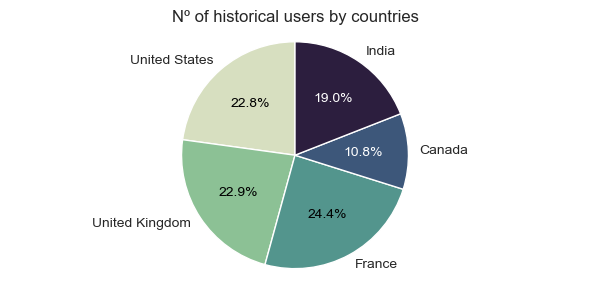

In [4]:
counts_aux = df.groupby(['billingCountry'])['userId'].nunique()
tot = sum(df.groupby(['billingCountry'])['userId'].nunique())
counts = (counts_aux/tot * 100).reindex(country_order)

plot_simple_pie_chart(counts, title='Nº of historical users by countries')

> US, UK and France lead the market share. India is a close 4th while Canada lags behind.

_Which country generates the most revenue?_

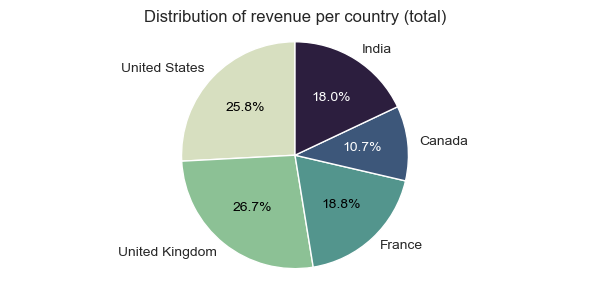

In [5]:
counts = df.groupby(['billingCountry'])['mrr'].sum().reindex(country_order)
plot_simple_pie_chart(counts, title='Distribution of revenue per country (total)')

> US and UK account for 50% of the total revenue.

_How are products distributed globally?_ (last month)

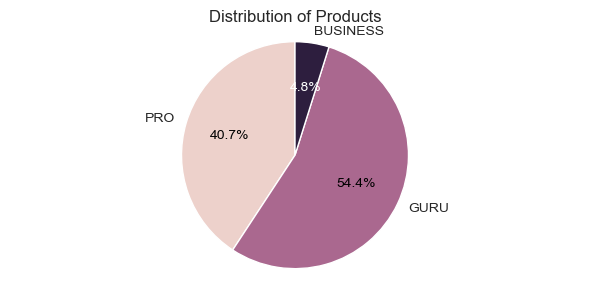

In [6]:
counts = df_last_month['product'].value_counts(normalize=True).reindex(product_order)
plot_simple_pie_chart(counts, title='Distribution of Products', color_palette=colors_pie_product)

> In the last month of data, we can see that GURU product accounts for more than half the active subscriptions

_What product brings the more revenuve globally?_ (last month)

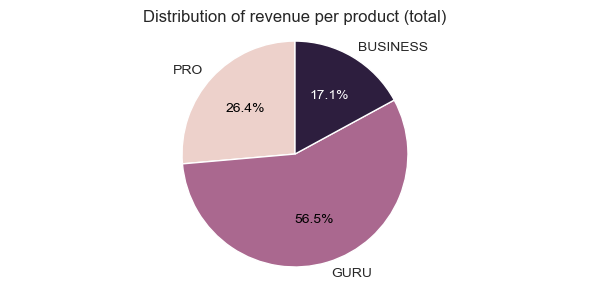

In [7]:
counts = df.groupby(['product'])['mrr'].sum().reindex(product_order)
plot_simple_pie_chart(counts, title='Distribution of revenue per product (total)', color_palette=colors_pie_product)

> While BUSINESS only accounts for 4.8% of total subscriptions in the last months, it represents 17% of the total revenue in that month.

# Product and period over time

In [8]:
import pandas as pd
from src.processing import calculate_proportions
from src.plot import plot_compare, color_dict_product

In [9]:
df_tmp = df.copy()
df_tmp_transactions = df_transactions.copy()

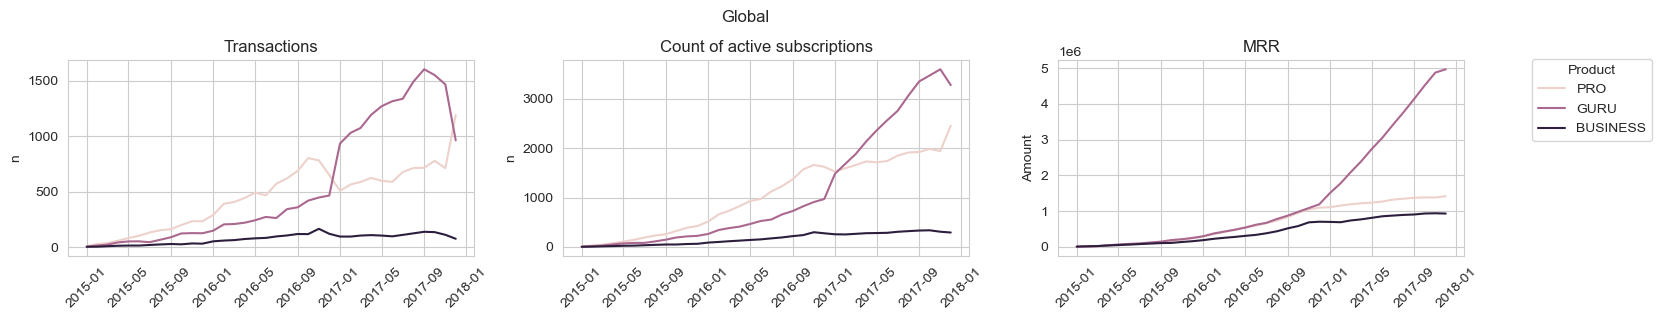

     mrr_month   product      amount        pct
105 2017-12-01  BUSINESS   933112.85  12.742092
106 2017-12-01      GURU  4971491.87  67.888045
107 2017-12-01       PRO  1418469.42  19.369863


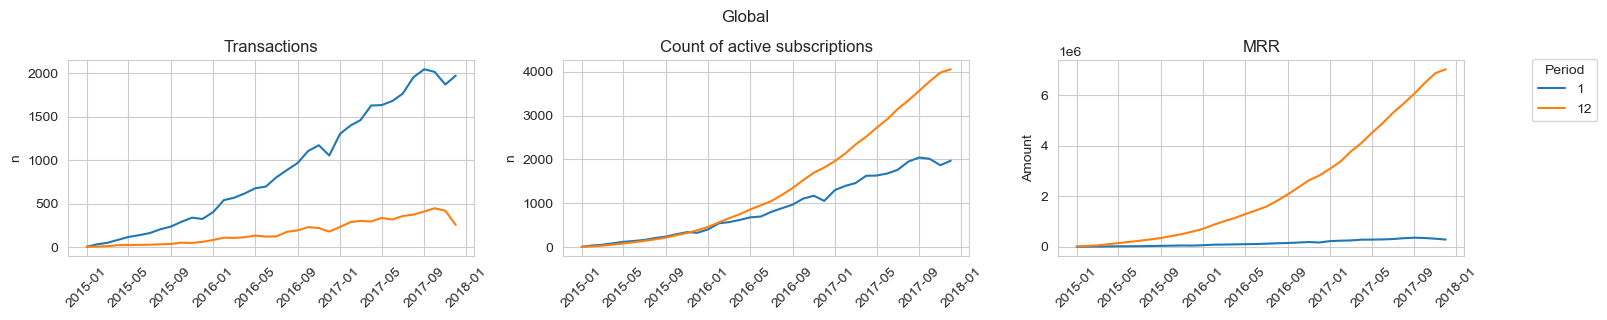

    mrr_month  period      amount        pct
70 2017-12-01       1   287020.76   3.919403
71 2017-12-01      12  7036053.38  96.080597


In [10]:
# By product
group_cols = ['product']
hue_col = 'product'
title = 'Global'

df_active_users = calculate_proportions(df=df_tmp, date_col='mrr_month', group_cols=group_cols)
df_transactions_aux = (
    df_tmp_transactions
    .set_index('datetime')
    .groupby([pd.Grouper(freq='MS')] + group_cols)
    .size()
    .reset_index()
    .rename(columns={0: 'n', 'datetime': 'mrr_month'})
)
df_amount = df_tmp.set_index('mrr_month').groupby([pd.Grouper(freq='MS')] + group_cols)['amount'].sum().reset_index()
plot_compare(
    df_active_users=df_active_users,
    df_transactions=df_transactions_aux,
    df_amount=df_amount,
    x_col='mrr_month',
    title=title,
    hue_col=hue_col,
    hue_order=product_order,
    hue_color_dict=color_dict_product,
)
df_amount['pct'] = df_amount.groupby('mrr_month')['amount'].apply(lambda x: (x / x.sum()) * 100).values
print(df_amount.loc[df_amount['mrr_month'] == df_amount['mrr_month'].max()])


# By period
group_cols = ['period']
hue_col = 'period'

df_active_users = calculate_proportions(df=df_tmp, date_col='mrr_month', group_cols=group_cols)
df_transactions_aux = (
    df_tmp_transactions
    .set_index('datetime')
    .groupby([pd.Grouper(freq='MS')] + group_cols)
    .size()
    .reset_index()
    .rename(columns={0: 'n', 'datetime': 'mrr_month'})
)
df_amount = df_tmp.set_index('mrr_month').groupby([pd.Grouper(freq='MS')] + group_cols)['amount'].sum().reset_index()
plot_compare(
    df_active_users=df_active_users,
    df_transactions=df_transactions_aux,
    df_amount=df_amount,
    x_col='mrr_month',
    title=title,
    hue_col=hue_col,
)
df_amount['pct'] = df_amount.groupby('mrr_month')['amount'].apply(lambda x: (x / x.sum()) * 100).values
print(df_amount.loc[df_amount['mrr_month'] == df_amount['mrr_month'].max()])

> Globally, we can see that from 2017 there is a clear shift in trend from PRO to GURU products.

> At the end of 2018, we can see another shift in transactions, shifting again from GURU to PRO.

> For monthly subscriptions, the impact of transaction slowdown is immediate in the following month when observing active subscriptions. The fact that we can see a downward trend on active subscriptions (be it from PRO or GURU products) a month later already tells us that the majority of users are only subbed for one month.

> Focusing on MRR, we can see that the anual subscribers bring in a lot more revenue that monthly subscribers (in the last month, 96% of the revenue was from anual subscriptions). By product, 'GURU' brings 2/3 of the revenue in the last month.

> Again looking at MRR, GURU is the most profitable product by quite a margin.

##### Combined plot

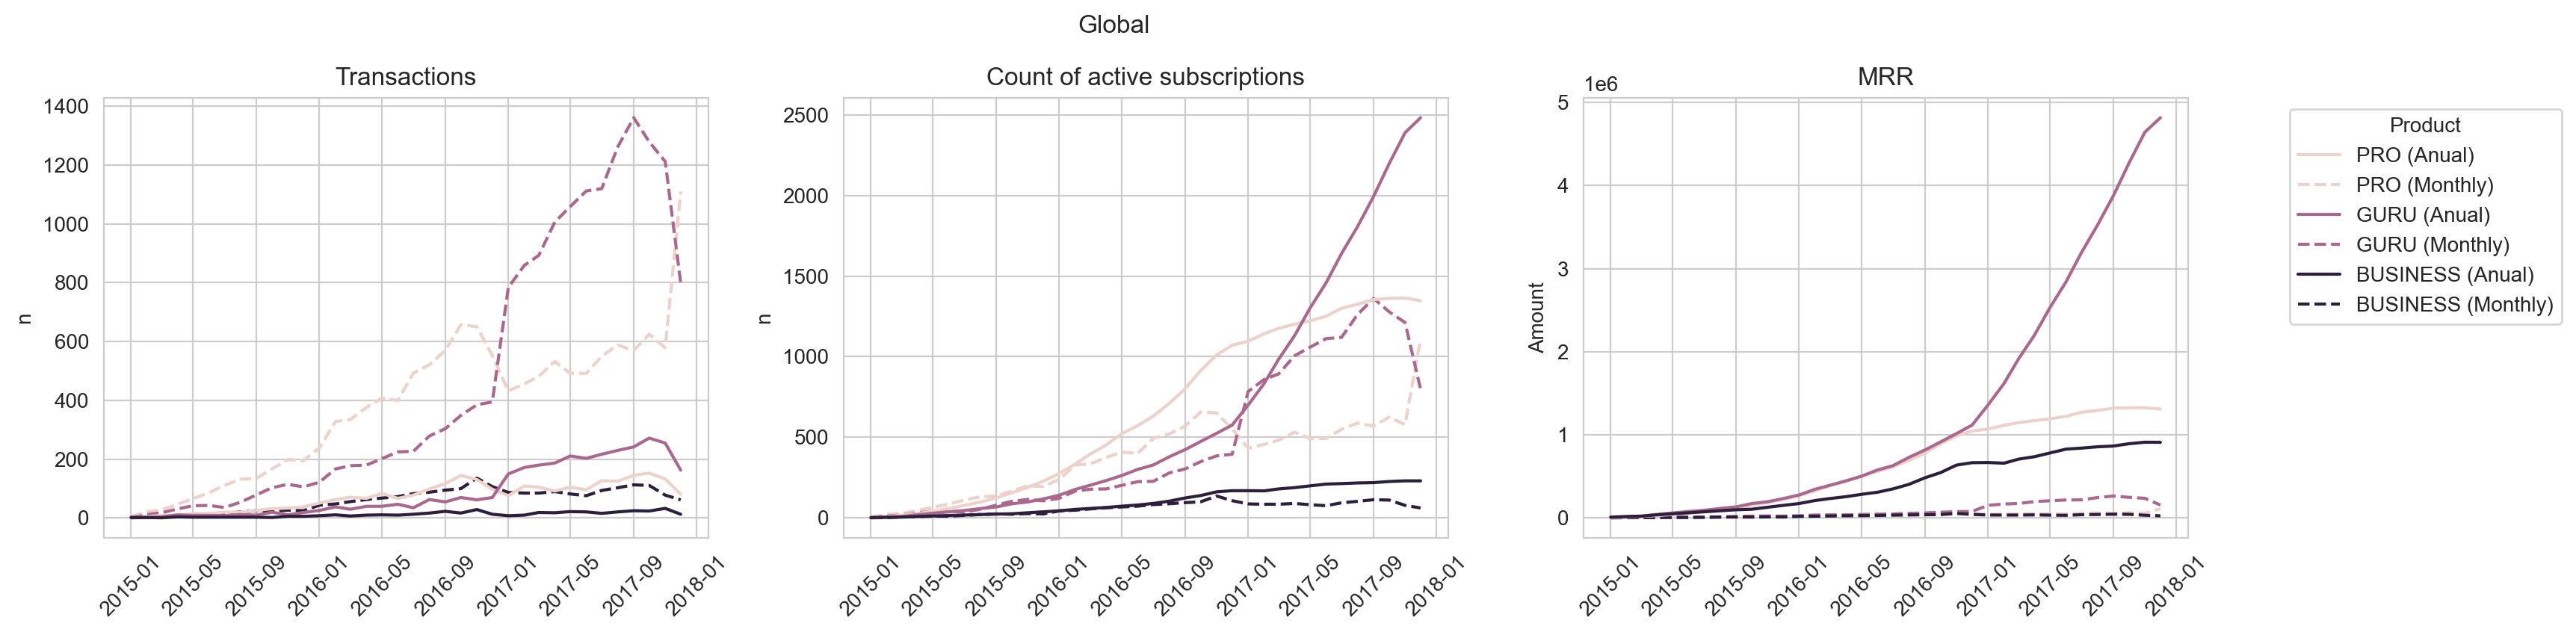

In [11]:
df_tmp = df.copy()
df_tmp_transactions = df_transactions.copy()

group_cols = ['product', 'period']
hue_col = 'product'
title = 'Global'

df_active_users = calculate_proportions(df=df_tmp, date_col='mrr_month', group_cols=group_cols)

df_transactions_aux = (
    df_tmp_transactions
    .set_index('datetime')
    .groupby([pd.Grouper(freq='MS')] + group_cols)
    .size()
    .reset_index()
    .rename(columns={0: 'n', 'datetime': 'mrr_month'})
)

df_amount = df_tmp.set_index('mrr_month').groupby([pd.Grouper(freq='MS')] + group_cols)['amount'].sum().reset_index()

plot_compare(
    df_active_users=df_active_users,
    df_transactions=df_transactions_aux,
    df_amount=df_amount,
    x_col='mrr_month',
    title=title,
    hue_col=hue_col,
    hue_order=product_order,
    hue_color_dict=color_dict_product,
    b_detail_period=True,
    figsize=(15,4),
    dpi=200,
)

> As expected, the dotted lines correlate by 1 month between transactions and active subscriptions

Going product by product

1. PRO:
    - Anual transactions slowdown but strong monthly uptrend. These will salvage a few month of MRR in the short term, but long term will be impacted.
2. GURU:    
    - Both anual and monthly transactions are slowing down, we can expect a drop in MRR in the following months.
3. BUSINESS:
    - Both anual and monthly transactions are also slowing down, we can also expect a dro in MRR in the following months.

# Last year

> We can focus on last year to confirm what we assesed from above

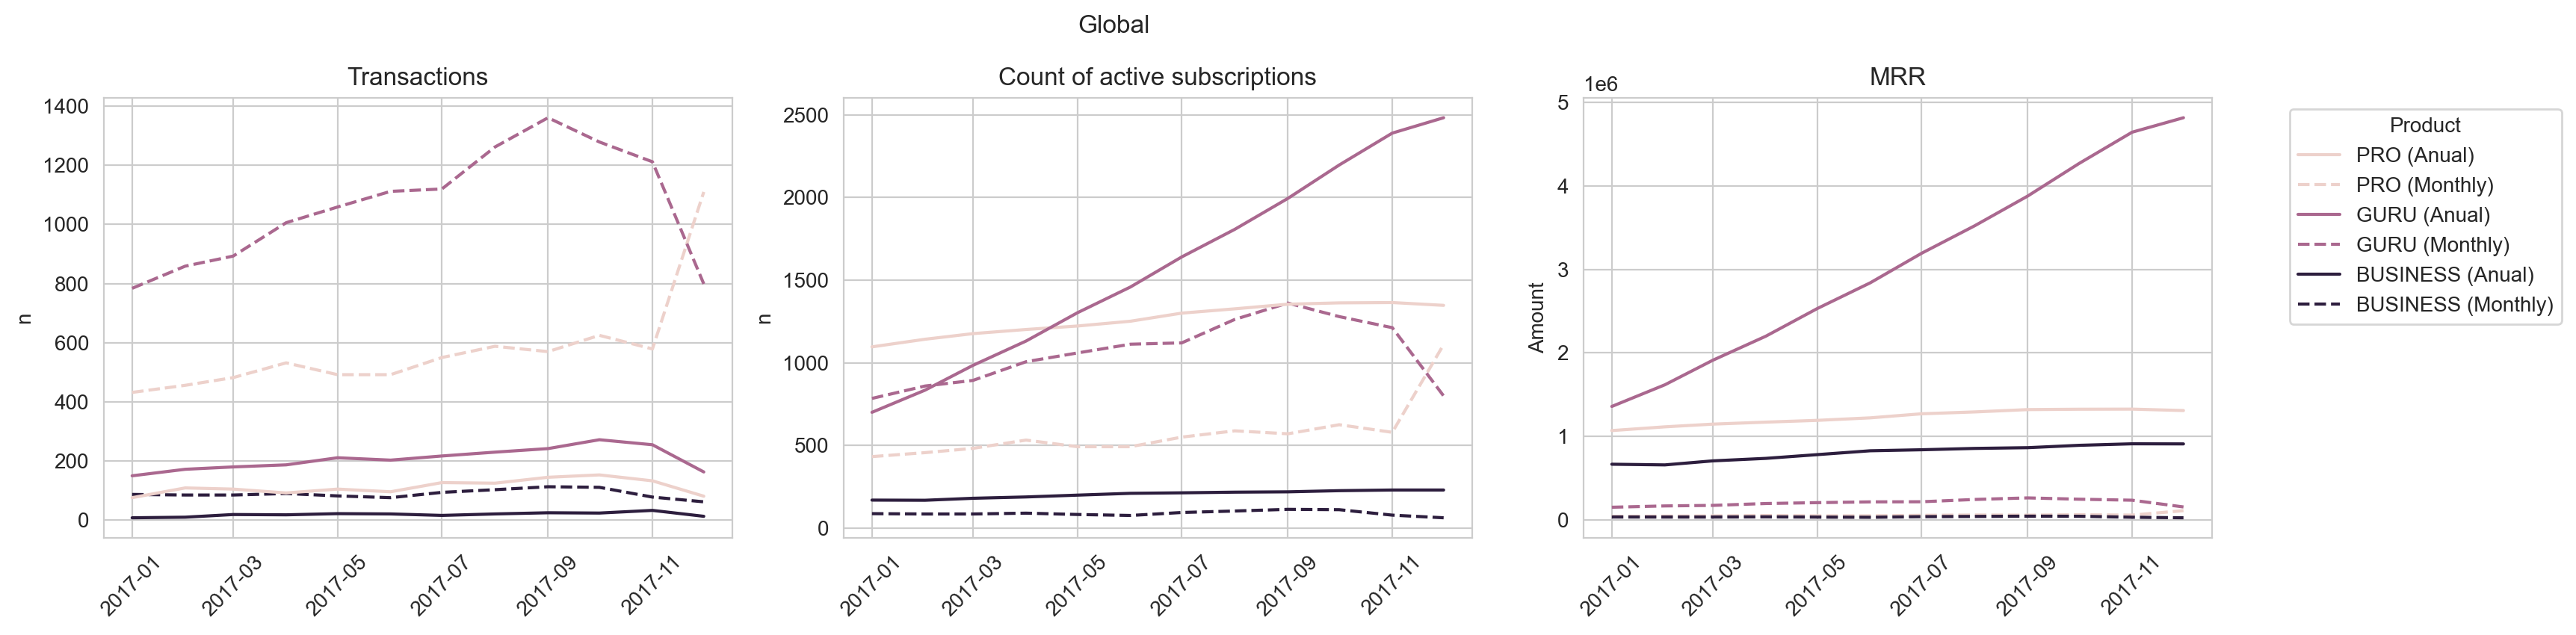

In [12]:
df_tmp = df.loc[df['mrr_month'].dt.year == 2017].copy()
df_tmp_transactions = df_transactions.loc[df_transactions['datetime'].dt.year == 2017]

# By product
group_cols = ['product', 'period']
hue_col = 'product'
title = 'Global'

df_active_users = calculate_proportions(df=df_tmp, date_col='mrr_month', group_cols=group_cols)

df_transactions_aux = (
    df_tmp_transactions
    .set_index('datetime')
    .groupby([pd.Grouper(freq='MS')] + group_cols)
    .size()
    .reset_index()
    .rename(columns={0: 'n', 'datetime': 'mrr_month'})
)

df_amount = df_tmp.set_index('mrr_month').groupby([pd.Grouper(freq='MS')] + group_cols)['amount'].sum().reset_index()

plot_compare(
    df_active_users=df_active_users,
    df_transactions=df_transactions_aux,
    df_amount=df_amount,
    x_col='mrr_month',
    title=title,
    hue_col=hue_col,
    hue_order=product_order,
    hue_color_dict=color_dict_product,
    b_detail_period=True,
    figsize=(15,4),
    dpi=200,
)

> Focusing on last year, we can see that the number of transactions for monthly users has a peak in sept. 2017
> MRR of GURU products slowdowns from oct, which makes sense due to transactions slowding down from sept.

*This is the same plot but spearating the monthly and anual subscriptions*

In [13]:
from src.plot import plot_anual_vs_monthly_by_product

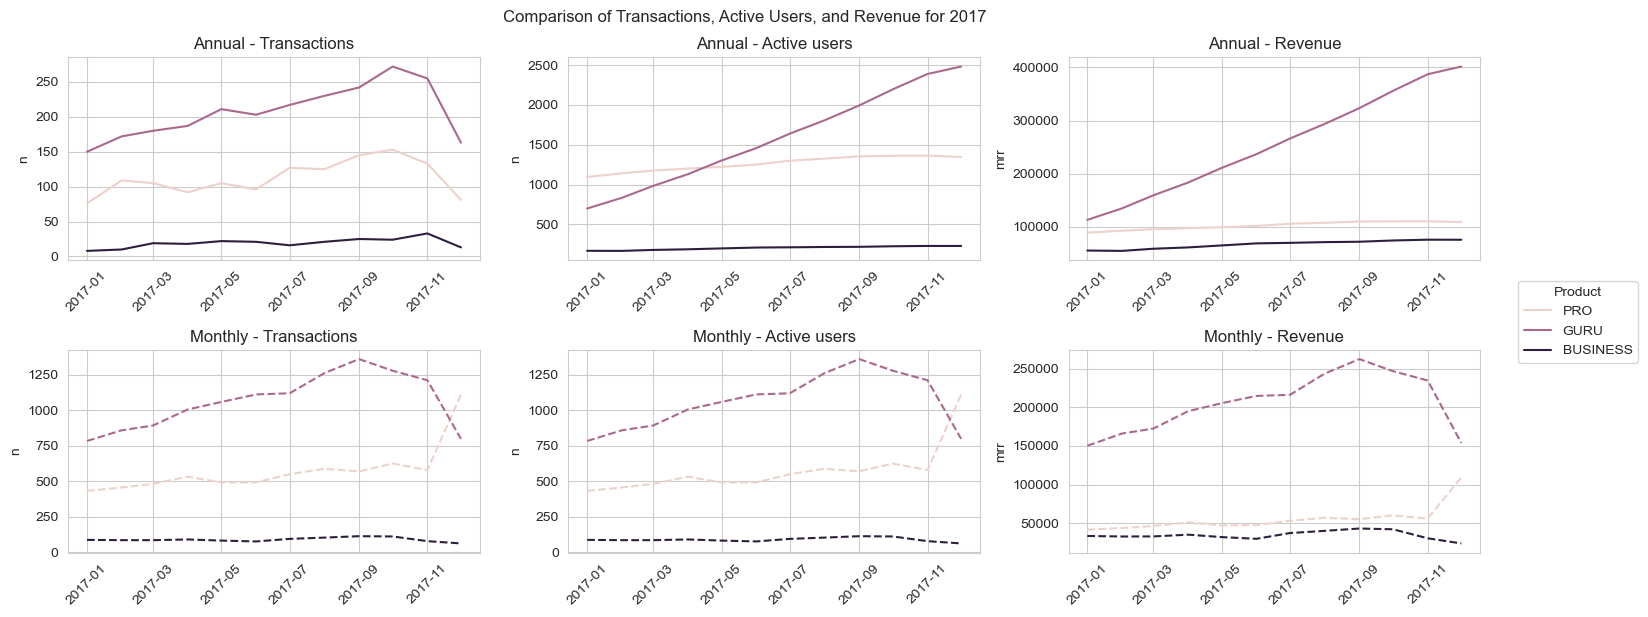

In [14]:
plot_anual_vs_monthly_by_product(df, df_transactions, 2017, product_order, color_dict_product)

> We can only confirm what we said earlier for each product

# Forecast

## Baseline

In [15]:
from src.model import get_baseline_predictions, display_baseline_metrics_and_predictions
from src.plot import plot_baseline_predictions

**Predictions**

In [16]:
mrr_monthly = df.groupby([pd.Grouper(key='mrr_month', freq='MS'), 'product'])['mrr'].sum().unstack().fillna(0)
baseline_metrics, baseline_predictions, baseline_future_predictions = get_baseline_predictions(mrr_monthly=mrr_monthly)

Calculating baseline predictions..
Done calculating baseline predictions.


__Results__

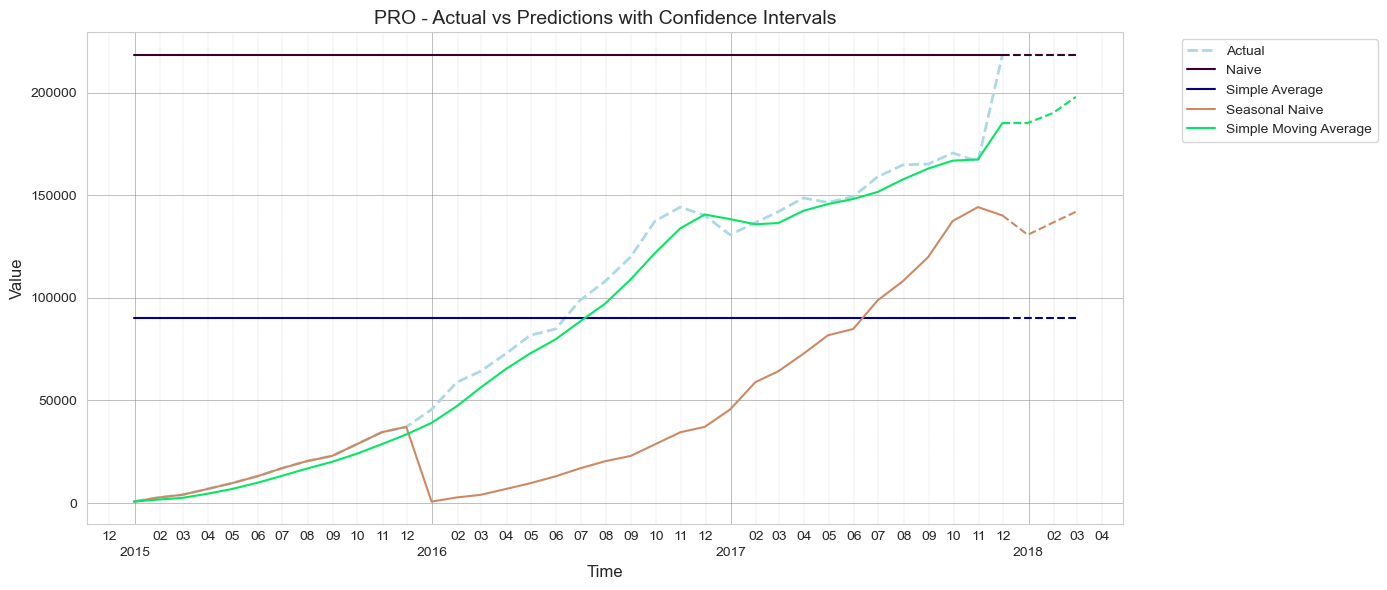

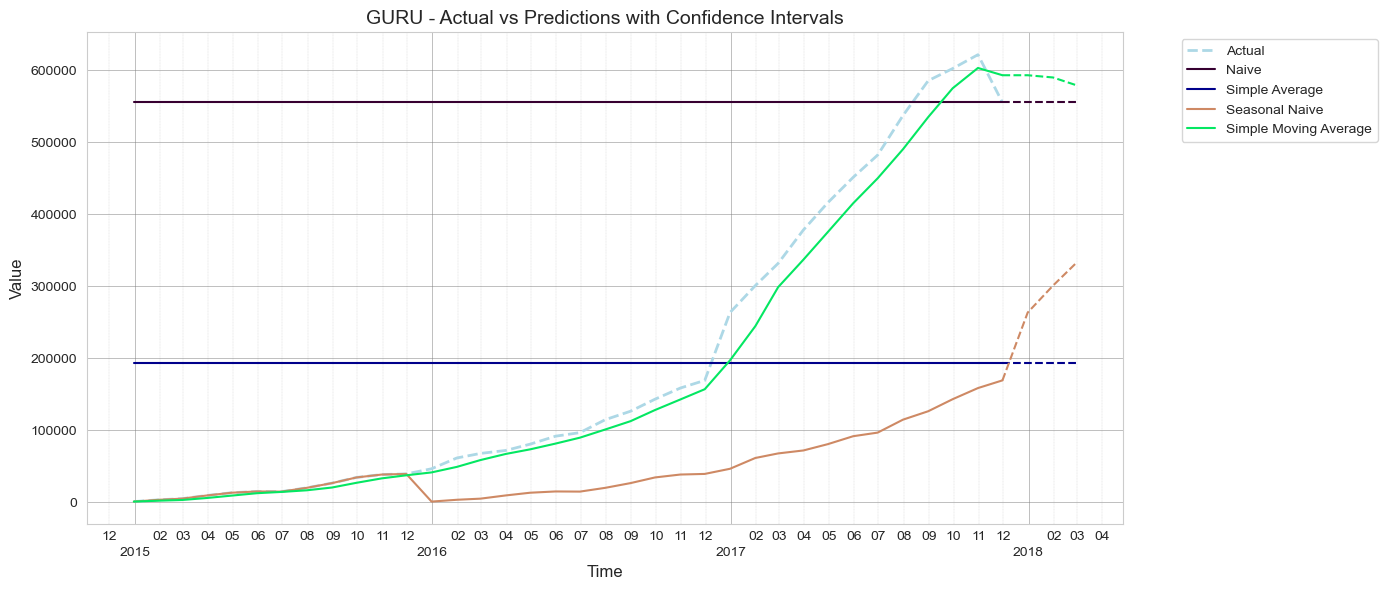

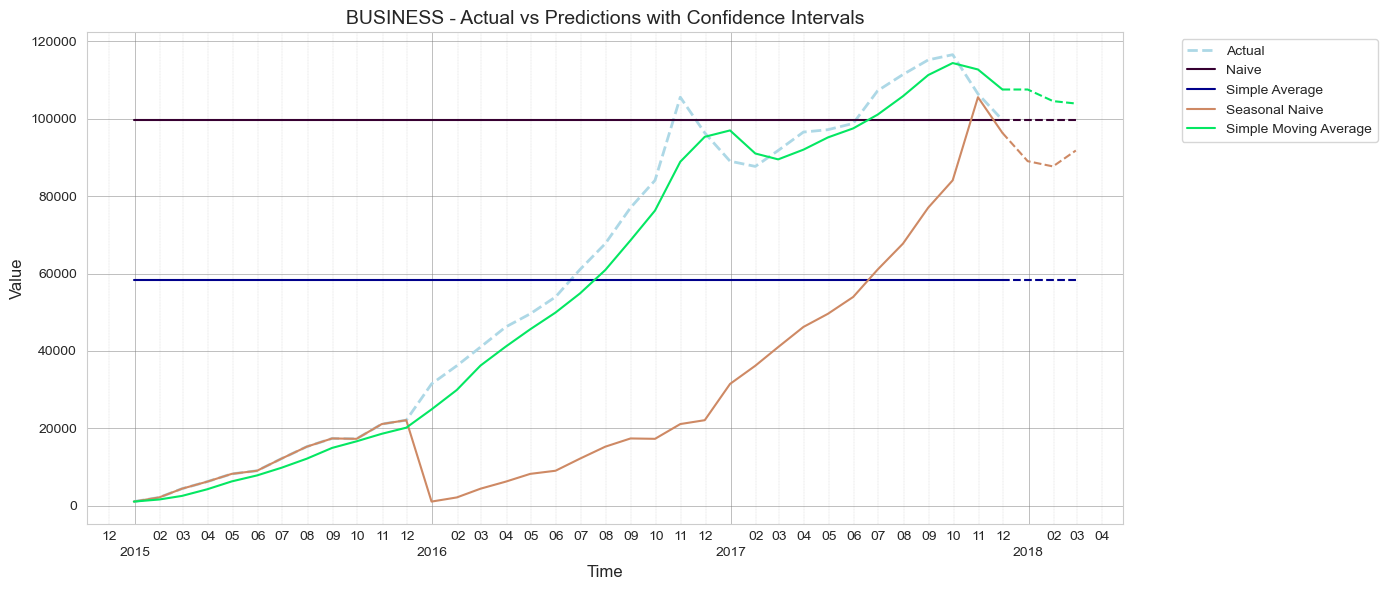

In [17]:
palette = [
    'lightblue',
    '#370031ff',
    'darkblue',
    '#ce8964ff',
    '#04E762',
]

plot_baseline_predictions(baseline_predictions, baseline_future_predictions, product_order, palette=palette)

**Metrics**

In [18]:
display_baseline_metrics_and_predictions(baseline_metrics, baseline_future_predictions)


Metrics and Predictions for PRO:
Baseline Metrics:
  Naive:
    MAE: 125584.72
    RMSE: 139886.41
  Simple Average:
    MAE: 56706.50
    RMSE: 62615.50
  Seasonal Naive:
    MAE: 70867.33
    RMSE: 74118.66
  Simple Moving Average:
    MAE: 6534.74
    RMSE: 8859.85

Future Predictions (with 95% Confidence Intervals):
  Naive:
    Month 1: 218497.28 (95% CI: 200041.66 - 236952.89)
    Month 2: 218497.28 (95% CI: 192397.09 - 244597.46)
    Month 3: 218497.28 (95% CI: 186531.21 - 250463.34)
  Simple Average:
    Month 1: 90351.99 (95% CI: 68865.42 - 111838.55)
    Month 2: 90351.99 (95% CI: 68865.42 - 111838.55)
    Month 3: 90351.99 (95% CI: 68865.42 - 111838.55)
  Seasonal Naive:
    Month 1: 130718.84 (95% CI: -188854.79 - 450292.48)
    Month 2: 136676.23 (95% CI: -167331.59 - 440684.05)
    Month 3: 141940.50 (95% CI: -249433.65 - 533314.66)
  Simple Moving Average:
    Month 1: 185198.31 (95% CI: 113381.43 - 257015.19)
    Month 2: 190066.41 (95% CI: 124643.06 - 255489.76)
    M

## SARIMAX

In [19]:
from src.model import get_sarima_predictions, display_sarima_metrics_and_predictions
from src.plot import plot_sarima_predictions

**Predictions**

In [20]:
mrr_monthly = df.groupby([pd.Grouper(key='mrr_month', freq='MS'), 'product'])['mrr'].sum().unstack().fillna(0)
sarima_metrics, sarima_forecasts, sarima_observed = get_sarima_predictions(mrr_monthly)

Optimizing for BUSINESS
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=542.412, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=524.354, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=590.274, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=520.716, Time=0.09 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=524.245, Time=0.08 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=523.983, Time=0.13 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=511.852, Time=0.02 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=500.160, Time=0.32 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=506.895, Time=0.18 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=502.276, Time=0.34 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=542.438, Time=0.05 sec
 ARIMA(0,0,2)(1,1,0)[

C:\Users\Victor\miniconda3\envs\semrush\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                       
Dep. Variable:                                  PRO   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -261.813
Date:                              Sat, 05 Oct 2024   AIC                            529.626
Time:                                      18:11:59   BIC                            533.160
Sample:                                  01-01-2015   HQIC                           530.564
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.013     79.044      0.000       0.975       1.025
ma.S.L12      -0.70

**Plot**

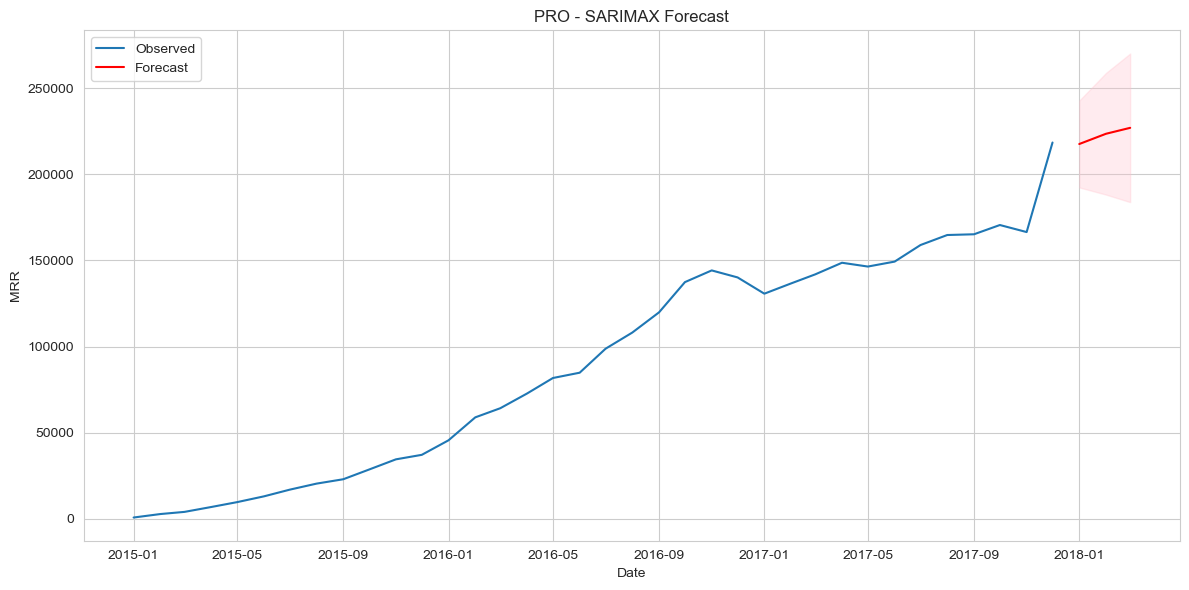

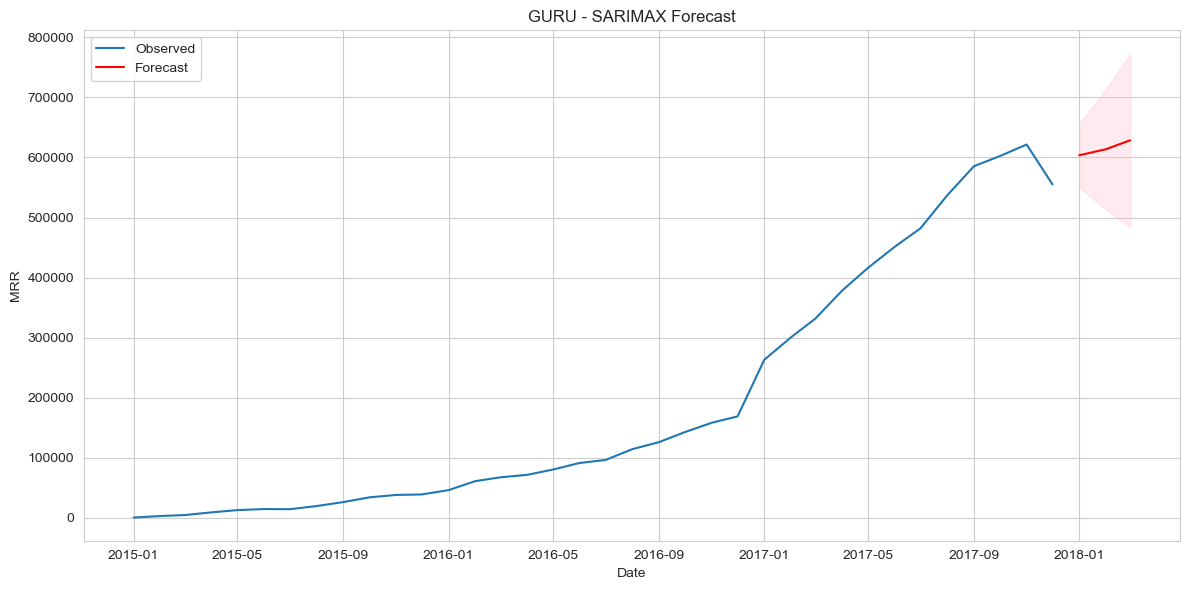

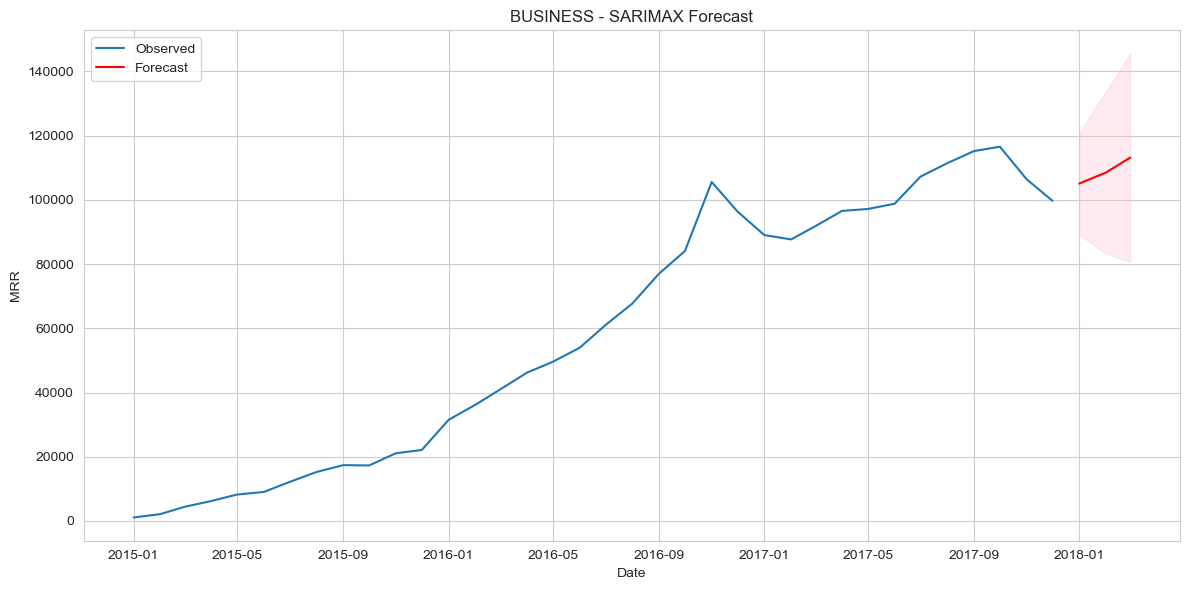

In [21]:
plot_sarima_predictions(sarima_observed, sarima_forecasts)

**Metrics**

In [22]:
display_sarima_metrics_and_predictions(sarima_metrics, sarima_forecasts, mrr_monthly)


SARIMA metrics for BUSINESS:
  MAE: 3999.24
  RMSE: 5992.75
  AIC: 503.17

SARIMA metrics for GURU:
  MAE: 11315.30
  RMSE: 21702.46
  AIC: 538.10

SARIMA metrics for PRO:
  MAE: 6600.83
  RMSE: 10968.47
  AIC: 529.63

BUSINESS MRR Forecast:
2018-01: $105071.38 (95% CI: $89134.04 - $121008.71)
2018-02: $108519.95 (95% CI: $83298.09 - $133741.81)
2018-03: $113155.04 (95% CI: $80736.74 - $145573.33)

GURU MRR Forecast:
2018-01: $603677.26 (95% CI: $550335.38 - $657019.14)
2018-02: $613830.74 (95% CI: $513456.33 - $714205.14)
2018-03: $628619.72 (95% CI: $484191.11 - $773048.33)

PRO MRR Forecast:
2018-01: $217635.49 (95% CI: $192429.86 - $242841.12)
2018-02: $223584.70 (95% CI: $188249.48 - $258919.92)
2018-03: $227032.11 (95% CI: $183886.19 - $270178.03)


## Prophet

In [23]:
from src.model import get_prophet_predictions, display_metrics_and_predictions
from src.plot import plot_prophet_predictions

__Predictions__

In [24]:
mrr_monthly = df.groupby([pd.Grouper(key='mrr_month', freq='MS'), 'product'])['mrr'].sum().unstack().reset_index()
prophet_data, prophet_metrics, prophet_forecasts = get_prophet_predictions(mrr_monthly)

18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing


__Plot__

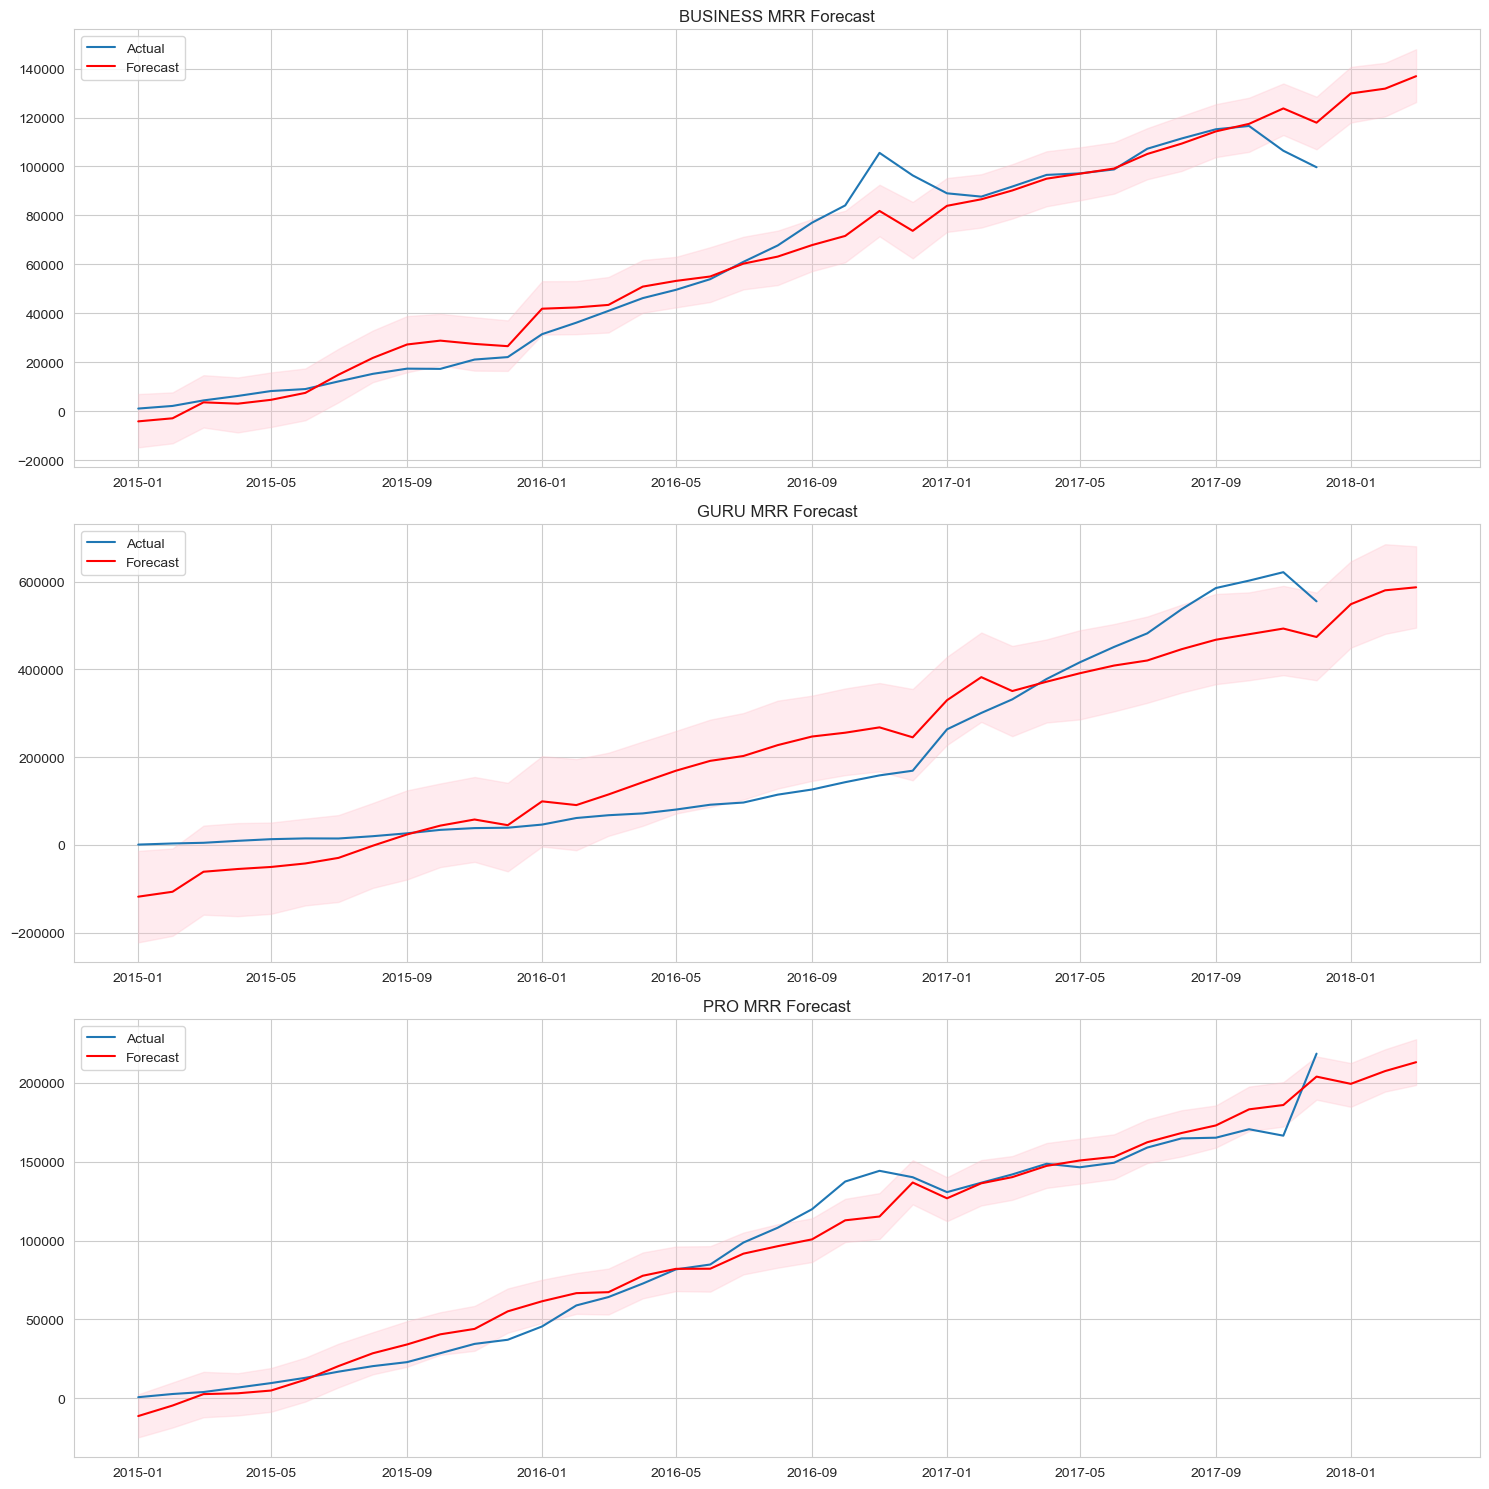

In [25]:
plot_prophet_predictions(prophet_data, prophet_forecasts)

__Metrics__

In [26]:
display_metrics_and_predictions(prophet_metrics, prophet_forecasts)


Metrics for BUSINESS:
MAE: 5942.803313861239
RMSE: 8530.162221283774

Metrics for GURU:
MAE: 68158.39858311276
RMSE: 78304.20891457384

Metrics for PRO:
MAE: 8293.816566428526
RMSE: 10859.68573664093

BUSINESS MRR Forecast:
2018-01: $129839.02 (95% CI: $117940.50 - $140693.26)
2018-02: $131806.61 (95% CI: $120456.11 - $142346.83)
2018-03: $136894.74 (95% CI: $126304.49 - $147905.79)

GURU MRR Forecast:
2018-01: $548621.09 (95% CI: $449484.46 - $646221.34)
2018-02: $580272.80 (95% CI: $481015.49 - $685308.49)
2018-03: $587153.87 (95% CI: $495132.29 - $680613.08)

PRO MRR Forecast:
2018-01: $199358.18 (95% CI: $184810.18 - $212532.86)
2018-02: $207462.92 (95% CI: $194467.27 - $221270.25)
2018-03: $213080.07 (95% CI: $198615.73 - $227635.47)


# Comparison

## Metrics

In [27]:
from src.model import get_comparative_metrics

df_metrics = get_comparative_metrics(baseline_metrics, sarima_metrics, prophet_metrics)
df_metrics.sort_values(by=['Product', 'MAE'])

MAE           RMSE         AIC
Product  Model                                                          
BUSINESS SARIMA                   3999.240687    5992.754160  503.170560
         Simple Moving Average    4521.197239    5496.140711         NaN
         Prophet                  5942.803314    8530.162221         NaN
         Simple Average          36514.204583   39781.367595         NaN
         Naive                   43272.749214   55669.504250         NaN
         Seasonal Naive          45047.215868   48509.343817         NaN
GURU     SARIMA                  11315.299050   21702.464032  538.104632
         Simple Moving Average   19660.942803   26600.949035         NaN
         Prophet                 68158.398583   78304.208915         NaN
         Simple Average         177881.568503  204820.034313         NaN
         Seasonal Naive         221128.808090  267357.849966         NaN
         Naive                  364280.515000  410892.102237         NaN
PRO      Simple Moving Average    6534.742138    8859.846014         NaN
         SARIMA                   6600.829428   10968.469358  529.626329
         Prophet                  8293.816566   10859.685737         NaN
         Simple Average          56706.497431   62615.497412         NaN
         Seasonal Naive          70867.329549   74118.660519         NaN
         Naive                  125584.718214  139886.406505         NaN

Overall observations:
- Generally MAE and RMSE are relativelay close to each other, suggesting there is not variance in the errors
- ARIMA performs best for the BUSINESS and GURU category, while SMA performs slightly better than ARIMA, although the differences are not very large
- Given the simplicity of the SMA vs the ARIMA, I would be inclined to use this model instead of the ARIMA (assuming I don't have any other information available)
- PROPHET model seems so stick to the trend too much.



## Forecasts

In [28]:
from src.model import get_comparative_forecasts

df_forecast_metrics = get_comparative_forecasts(baseline_future_predictions, prophet_forecasts, sarima_forecasts)
df_forecast_metrics

Forecast      Lower CI  \
Product  Model                 Month                                
PRO      Naive                 1      218497.276667  2.000417e+05   
                               2      218497.276667  1.923971e+05   
                               3      218497.276667  1.865312e+05   
         Simple Average        1       90351.985301  6.886542e+04   
                               2       90351.985301  6.886542e+04   
                               3       90351.985301  6.886542e+04   
         Seasonal Naive        1      130718.842500 -1.888548e+05   
                               2      136676.231667 -1.673316e+05   
                               3      141940.503333 -2.494337e+05   
         Simple Moving Average 1      185198.306944  1.133814e+05   
                               2      190066.410093  1.246431e+05   
                               3      197920.664568  1.532426e+05   
         Prophet               1      199358.182950  1.848102e+05   
                               2      207462.915024  1.944673e+05   
                               3      213080.074954  1.986157e+05   
         SARIMA                1      217635.490502  1.924299e+05   
                               2      223584.700095  1.882495e+05   
                               3      227032.111211  1.838862e+05   
GURU     Naive                 1      555175.744167  5.077143e+05   
                               2      555175.744167  4.880552e+05   
                               3      555175.744167  4.729702e+05   
         Simple Average        1      193607.966968  1.233238e+05   
                               2      193607.966968  1.233238e+05   
                               3      193607.966968  1.233238e+05   
         Seasonal Naive        1      263388.615833 -1.034124e+06   
                               2      300748.323333 -1.024561e+06   
                               3      331698.047500 -8.231722e+05   
         Simple Moving Average 1      593045.875278  5.081399e+05   
                               2      589942.023426  5.071632e+05   
                               3      579387.880957  5.271572e+05   
         Prophet               1      548621.086525  4.494845e+05   
                               2      580272.795651  4.810155e+05   
                               3      587153.866081  4.951323e+05   
         SARIMA                1      603677.262617  5.503354e+05   
                               2      613830.737259  5.134563e+05   
                               3      628619.715434  4.841911e+05   
BUSINESS Naive                 1       99685.520833  8.872213e+04   
                               2       99685.520833  8.418095e+04   
                               3       99685.520833  8.069638e+04   
         Simple Average        1       58447.441111  4.479643e+04   
                               2       58447.441111  4.479643e+04   
                               3       58447.441111  4.479643e+04   
         Seasonal Naive        1       89031.404167 -1.287376e+05   
                               2       87679.430833 -1.232109e+05   
                               3       91791.330833 -9.691491e+04   
         Simple Moving Average 1      107555.198333  8.646317e+04   
                               2      104555.625833  9.398501e+04   
                               3      103932.115000  9.406582e+04   
         Prophet               1      129839.016079  1.179405e+05   
                               2      131806.613771  1.204561e+05   
                               3      136894.739548  1.263045e+05   
         SARIMA                1      105071.376430  8.913404e+04   
                               2      108519.952675  8.329809e+04   
                               3      113155.037228  8.073674e+04   

                                          Upper CI  
Product  Model                 Month                
PRO      Naive                 1      2.369529e+05  
                   

In [29]:
df_export = df_forecast_metrics.reset_index()
df_export = df_export.loc[df_export['Model']=='Simple Moving Average']
df_export.to_csv('results/forecast.csv', sep=',', index=False)

In [30]:
# used for quick avg calculations
# mean_aux_list = []
# for product in product_order:
#     data = sarima_observed[product]
#     mean_aux = data.loc[data.index >= '2017-01-01'].mean()
#     mean_aux_list.append(mean_aux)
#     print(f"{product} - Average from 2017: {mean_aux:.2f}")